In [1]:
import ffsim
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister

from extended_matchgate_simulator.exact import exact_calculation
from extended_matchgate_simulator.raw_estimation import raw_estimate
from extended_matchgate_simulator.utils import (
    calculate_trajectory_count,
    extract_circuit_data,
    ucj_to_compatible,
)

In [2]:
norb = 16
nelec = (norb // 4, norb // 4)
pairs_aa = [(p, p + 1) for p in range(norb - 1)]
pairs_ab = [(p, p) for p in range(norb)]

ucj_op = ffsim.random.random_ucj_op_spin_balanced(
    norb,
    n_reps=1,
    interaction_pairs=(pairs_aa, pairs_ab),
    with_final_orbital_rotation=True,
    diag_coulomb_scale=1e-1,
    diag_coulomb_normal=True,
)

qubits = QuantumRegister(2 * norb, name="q")
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit = ucj_to_compatible(circuit)
circuit = ffsim.qiskit.PRE_INIT.run(circuit)

In [3]:
reference_vec = ffsim.apply_unitary(
    ffsim.hartree_fock_state(norb, nelec), ucj_op, norb=norb, nelec=nelec
)
exact_vec = ffsim.qiskit.final_state_vector(circuit, norb=norb, nelec=nelec)
np.testing.assert_allclose(exact_vec, reference_vec)
exact_probs = np.abs(exact_vec) ** 2

In [4]:
bitstrings = ffsim.addresses_to_strings(
    range(ffsim.dim(norb, nelec)), norb=norb, nelec=nelec
)
# probs = exact_calculation(circuit=circuit, outcome_states=bitstrings)
# np.testing.assert_allclose(probs, exact_probs)

In [5]:
circuit_data = extract_circuit_data(circuit)
(
    num_qubits,
    extent,
    negative_mask,
    normalized_angles,
    initial_state,
    gate_types,
    params,
    qubits,
    orb_indices,
    orb_mats,
) = circuit_data

extent

3.9289390677992326

In [6]:
bitstring = bitstrings[0]
exact_prob = exact_probs[0]
epsilon = 1e-2 * exact_prob
delta = 1
p = 1
n_traj_theory = calculate_trajectory_count(epsilon, delta, extent, p)
n_traj_theory

336790473977386391044096

In [7]:
n_traj_range = [100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]
estimates = []
errors = []
for n_traj in n_traj_range:
    raw_est = raw_estimate(
        circuit=circuit, outcome_states=bitstring, trajectory_count=n_traj
    )
    estimates.append(raw_est)
    errors.append(abs(raw_est - exact_prob))

Text(0, 0.5, 'Error')

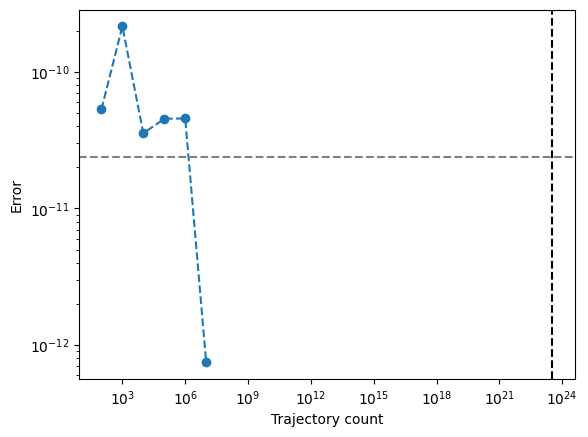

In [8]:
fig, ax = plt.subplots(1, 1)

ax.plot(n_traj_range, errors, "o--")
ax.axhline(epsilon, linestyle="--", color="gray")
ax.axvline(n_traj_theory, linestyle="--", color="black")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Trajectory count")
ax.set_ylabel("Error")